# Tugas Besar 2 IF3270 Pembelajaran Mesin - CNN
Kelompok 36
1. Shazya Audrea Taufik - 13522063
2. Evelyn Yosiana - 13522083
3. Zahira Dina Amalia - 13522085

## Import Libraries and Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
import pickle
import os
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.18.0
GPU Available: True


## Data Preparation

In [3]:
def load_and_prepare_cifar10():
    # Load CIFAR-10 dataset
    (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # Normalize pixel values to [0, 1]
    x_train_full = x_train_full.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Flatten labels
    y_train_full = y_train_full.flatten()
    y_test = y_test.flatten()

    # Split training data into 4:1 ratio
    split_idx = 40000
    x_train = x_train_full[:split_idx]
    y_train = y_train_full[:split_idx]
    x_val = x_train_full[split_idx:]
    y_val = y_train_full[split_idx:]

    print(f"Training set: {x_train.shape[0]} samples")
    print(f"Validation set: {x_val.shape[0]} samples")
    print(f"Test set: {x_test.shape[0]} samples")
    print(f"Image shape: {x_train.shape[1:]}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training set: 40000 samples
Validation set: 10000 samples
Test set: 10000 samples
Image shape: (32, 32, 3)
Number of classes: 10


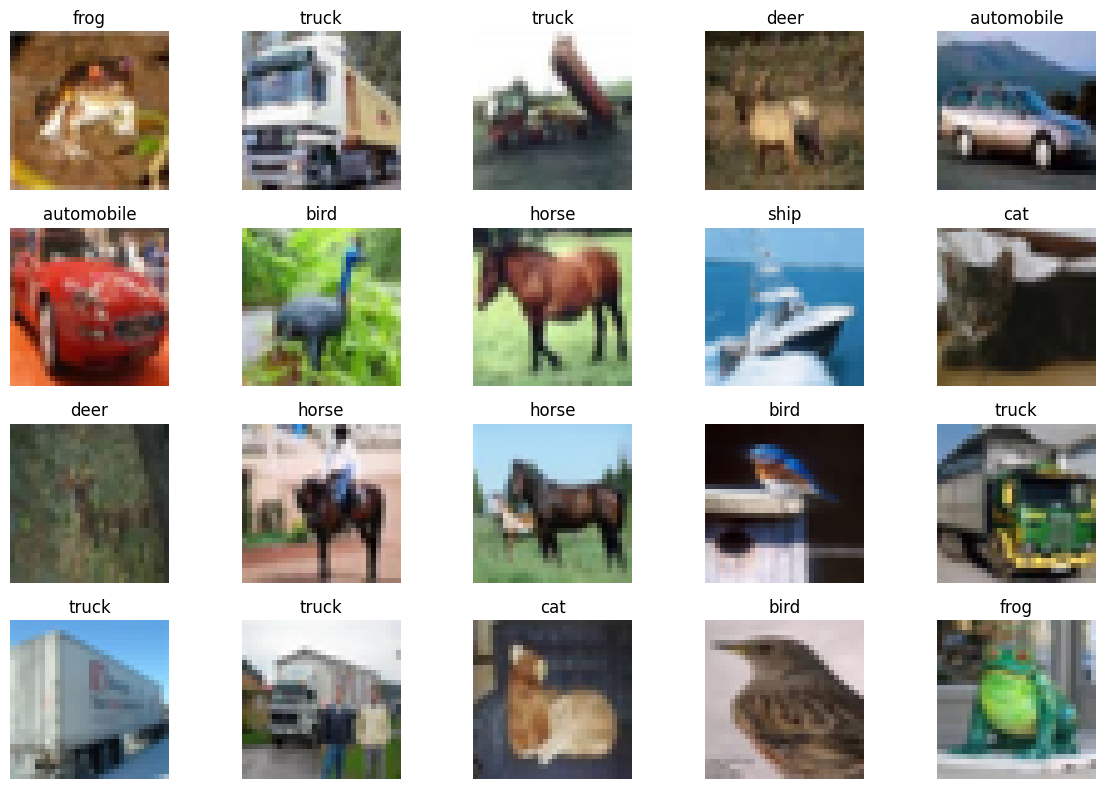

In [4]:
# Load data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_prepare_cifar10()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize sample
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f'{class_names[y_train[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Model

In [5]:
def create_cnn_model(conv_layers: List[int], filters_per_layer: List[int],
                    kernel_sizes: List[int], pooling_type: str = 'max'):
    model = keras.Sequential()

    # Input layer
    model.add(layers.Input(shape=(32, 32, 3)))

    # Convolutional layers
    for i, (n_layers, n_filters, kernel_size) in enumerate(zip(conv_layers, filters_per_layer, kernel_sizes)):
        for j in range(n_layers):
            model.add(layers.Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation='relu',
                padding='same',
                name=f'conv_{i}_{j}'
            ))

        # Pooling layer
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D(pool_size=(2, 2), name=f'maxpool_{i}'))
        else:
            model.add(layers.AveragePooling2D(pool_size=(2, 2), name=f'avgpool_{i}'))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', name='dense_1'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax', name='dense_output'))

    return model

In [6]:
def train_model(model, model_name: str, epochs: int = 20):
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    y_pred = model.predict(x_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    f1_macro = f1_score(y_test, y_pred_classes, average='macro')

    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-Score (Macro): {f1_macro:.4f}")

    # Save model
    model.save(f'models/{model_name}.h5')

    return history, test_acc, f1_macro

In [7]:
# Create models directory
os.makedirs('models', exist_ok=True)

## Percobaan

### Percobaan 1 : Pengaruh Jumlah Layer Konvolusi

In [ ]:
print("=" * 60)
print("Percobaan 1: Pengaruh Jumlah Layer Konvolusi")
print("=" * 60)

# Variasi 1: 2 Conv layers
model_1_conv = create_cnn_model(
    conv_layers=[1, 1],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 2: 4 Conv layers
model_2_conv = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 3: 6 Conv layers
model_3_conv = create_cnn_model(
    conv_layers=[3, 3],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Train models
models_conv = [
    (model_1_conv, "2_conv_layers"),
    (model_2_conv, "4_conv_layers"),
    (model_3_conv, "6_conv_layers")
]

results_conv = {}
for model, name in models_conv:
    print(f"\nTraining {name}...")
    model.summary()
    history, test_acc, f1_macro = train_model(model, name)
    results_conv[name] = {
        'history': history,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }

Percobaan 1: Pengaruh Jumlah Layer Konvolusi

Training 2_conv_layers...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_0_0 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_0 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_0 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3130 - loss: 1.8551 - val_accuracy: 0.5442 - val_loss: 1.2940
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5113 - loss: 1.3686 - val_accuracy: 0.6116 - val_loss: 1.1286
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5651 - loss: 1.2191 - val_accuracy: 0.6427 - val_loss: 1.0396
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5969 - loss: 1.1311 - val_accuracy: 0.6628 - val_loss: 0.9849
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6264 - loss: 1.0514 - val_accuracy: 0.6690 - val_loss: 0.9615
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6441 - loss: 0.9997 - val_accuracy: 0.6827 - val_loss: 0.9137
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6649 - loss: 0.9419 - val_accuracy: 0.6856 - val_loss: 0.9086
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6782 - loss: 0.8981 


2_conv_layers Results:
Test Accuracy: 0.6994
Test F1-Score (Macro): 0.6966

Training 4_conv_layers...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_0_0 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_0 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_0 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,274 (2.26 MB)

 Trainable params: 591,274 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.2794 - loss: 1.9109 - val_accuracy: 0.5503 - val_loss: 1.2678
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5248 - loss: 1.3209 - val_accuracy: 0.6263 - val_loss: 1.0384
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6027 - loss: 1.1262 - val_accuracy: 0.6583 - val_loss: 0.9674
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6363 - loss: 1.0182 - val_accuracy: 0.6837 - val_loss: 0.8901
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6770 - loss: 0.9168 - val_accuracy: 0.6987 - val_loss: 0.8504
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7086 - loss: 0.8435 - val_accuracy: 0.7018 - val_loss: 0.8409
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7232 - loss: 0.7924 - val_accuracy: 0.7142 - val_loss: 0.8184
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7399 - loss: 0.727


4_conv_layers Results:
Test Accuracy: 0.7244
Test F1-Score (Macro): 0.7226

Training 6_conv_layers...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_0_0 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_0 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_0 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 637,450 (2.43 MB)

 Trainable params: 637,450 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2501 - loss: 1.9998 - val_accuracy: 0.4888 - val_loss: 1.4081
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4828 - loss: 1.4310 - val_accuracy: 0.5701 - val_loss: 1.2047
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5719 - loss: 1.2066 - val_accuracy: 0.6400 - val_loss: 0.9958
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6239 - loss: 1.0626 - val_accuracy: 0.6771 - val_loss: 0.9081
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6602 - loss: 0.9623 - val_accuracy: 0.6953 - val_loss: 0.8725
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6898 - loss: 0.8790 - val_accuracy: 0.7020 - val_loss: 0.8420
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7106 - loss: 0.8176 - val_accuracy: 0.7235 - val_loss: 0.8209
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7331 - loss: 0.75


6_conv_layers Results:
Test Accuracy: 0.7261
Test F1-Score (Macro): 0.7237


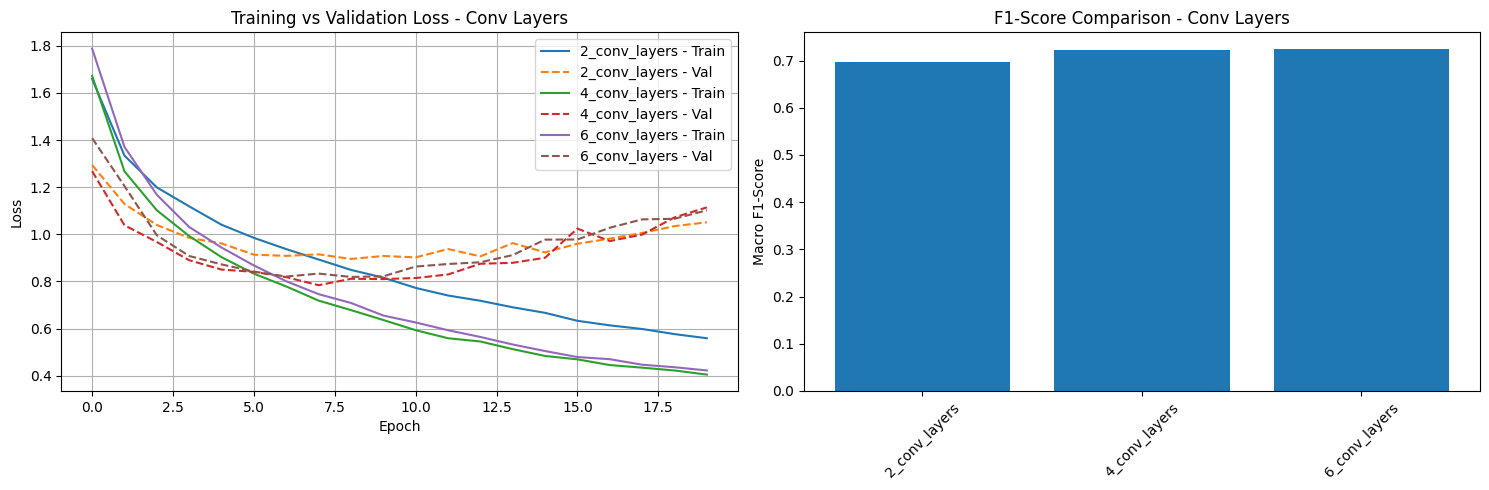

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, result in results_conv.items():
    history = result['history']
    axes[0].plot(history.history['loss'], label=f'{name} - Train')
    axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')

axes[0].set_title('Training vs Validation Loss - Conv Layers')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

names = list(results_conv.keys())
f1_scores = [results_conv[name]['f1_macro'] for name in names]
axes[1].bar(names, f1_scores)
axes[1].set_title('F1-Score Comparison - Conv Layers')
axes[1].set_ylabel('Macro F1-Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\nKesimpulan Percobaan 1:")
for name, result in results_conv.items():
    print(f"{name}: F1-Score = {result['f1_macro']:.4f}")


Kesimpulan Percobaan 1:
2_conv_layers: F1-Score = 0.6966
4_conv_layers: F1-Score = 0.7226
6_conv_layers: F1-Score = 0.7237


### Percobaan 2: Pengaruh Banyak Filter per Layer

In [ ]:
print("\n" + "=" * 60)
print("Percobaan 2: Pengaruh Banyak Filter per Layer")
print("=" * 60)

# Variasi 1: Sedikit filter
model_low_filters = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[16, 32],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 2: Sedang filter
model_med_filters = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 3: Banyak filter
model_high_filters = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[64, 128],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

models_filters = [
    (model_low_filters, "low_filters_16_32"),
    (model_med_filters, "med_filters_32_64"),
    (model_high_filters, "high_filters_64_128")
]

results_filters = {}
for model, name in models_filters:
    print(f"\nTraining {name}...")
    history, test_acc, f1_macro = train_model(model, name)
    results_filters[name] = {
        'history': history,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }


Percobaan 2: Pengaruh Banyak Filter per Layer

Training low_filters_16_32...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3031 - loss: 1.8826 - val_accuracy: 0.5285 - val_loss: 1.3221
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5110 - loss: 1.3562 - val_accuracy: 0.6092 - val_loss: 1.0949
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5807 - loss: 1.1781 - val_accuracy: 0.6438 - val_loss: 1.0032
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6232 - loss: 1.0732 - val_accuracy: 0.6606 - val_loss: 0.9492
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6523 - loss: 0.9934 - val_accuracy: 0.6811 - val_loss: 0.9162
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6691 - loss: 0.9320 - val_accuracy: 0.6817 - val_loss: 0.9081
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6921 - loss: 0.8738 - val_accuracy: 0.6907 - val_loss: 0.8860
Epoch 8/


low_filters_16_32 Results:
Test Accuracy: 0.7062
Test F1-Score (Macro): 0.7046

Training med_filters_32_64...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2958 - loss: 1.8946 - val_accuracy: 0.5420 - val_loss: 1.2651
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5152 - loss: 1.3449 - val_accuracy: 0.6114 - val_loss: 1.0837
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5964 - loss: 1.1346 - val_accuracy: 0.6658 - val_loss: 0.9438
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6413 - loss: 1.0066 - val_accuracy: 0.6961 - val_loss: 0.8590
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6770 - loss: 0.9137 - val_accuracy: 0.7097 - val_loss: 0.8417
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7065 - loss: 0.8440 - val_accuracy: 0.7225 - val_loss: 0.8052
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7195 - loss: 0.7842 - val_accuracy: 0.


med_filters_32_64 Results:
Test Accuracy: 0.7296
Test F1-Score (Macro): 0.7278

Training high_filters_64_128...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2882 - loss: 1.9176 - val_accuracy: 0.5501 - val_loss: 1.2453
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5239 - loss: 1.3223 - val_accuracy: 0.6266 - val_loss: 1.0381
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6087 - loss: 1.1058 - val_accuracy: 0.6709 - val_loss: 0.9284
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6535 - loss: 0.9786 - val_accuracy: 0.6989 - val_loss: 0.8601
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6882 - loss: 0.8759 - val_accuracy: 0.7120 - val_loss: 0.8158
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7174 - loss: 0.7958 - val_accuracy: 0.7237 - val_loss: 0.8133
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7372 - loss: 0.7315 - val_accuracy: 


high_filters_64_128 Results:
Test Accuracy: 0.7407
Test F1-Score (Macro): 0.7379


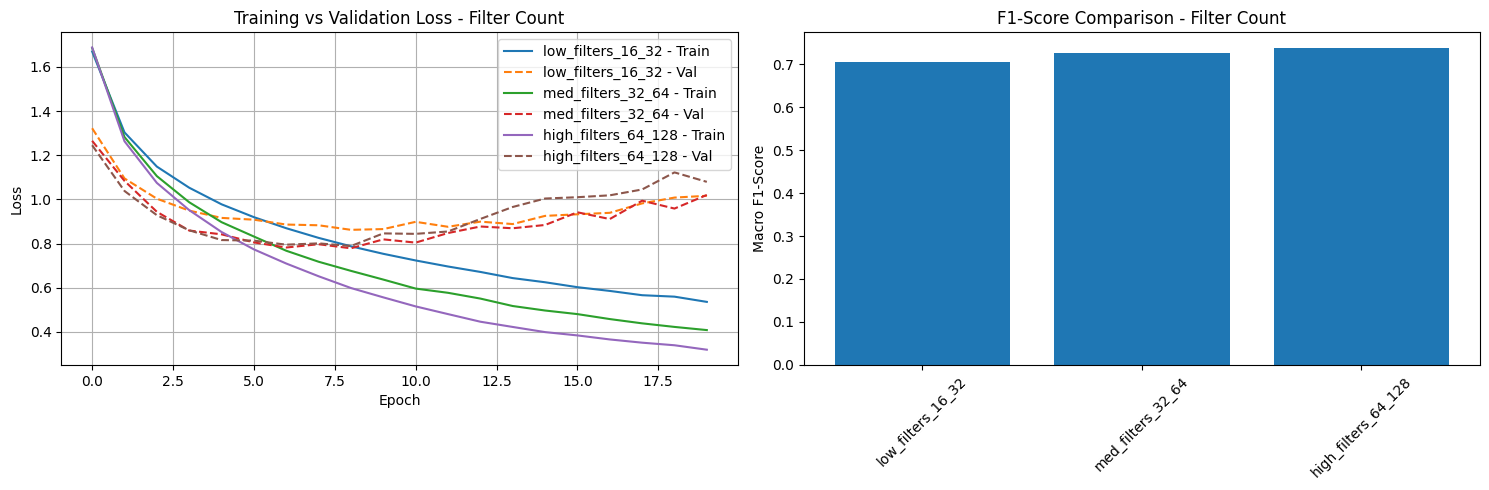

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, result in results_filters.items():
    history = result['history']
    axes[0].plot(history.history['loss'], label=f'{name} - Train')
    axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')

axes[0].set_title('Training vs Validation Loss - Filter Count')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

names = list(results_filters.keys())
f1_scores = [results_filters[name]['f1_macro'] for name in names]
axes[1].bar(names, f1_scores)
axes[1].set_title('F1-Score Comparison - Filter Count')
axes[1].set_ylabel('Macro F1-Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\nKesimpulan Percobaan 2:")
for name, result in results_filters.items():
    print(f"{name}: F1-Score = {result['f1_macro']:.4f}")


Kesimpulan Percobaan 2:
low_filters_16_32: F1-Score = 0.7046
med_filters_32_64: F1-Score = 0.7278
high_filters_64_128: F1-Score = 0.7379


### Percobaan 3: Pengaruh Ukuran Filter per Layer

In [ ]:
print("\n" + "=" * 60)
print("Percobaan 3: Pengaruh Ukuran Filter per Layer")
print("=" * 60)

# Variasi 1: Filter kecil (3x3)
model_small_kernel = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 2: Filter sedang (5x5)
model_med_kernel = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[5, 5],
    pooling_type='max'
)

# Variasi 3: Filter besar (7x7)
model_large_kernel = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[7, 7],
    pooling_type='max'
)

models_kernels = [
    (model_small_kernel, "kernel_3x3"),
    (model_med_kernel, "kernel_5x5"),
    (model_large_kernel, "kernel_7x7")
]

results_kernels = {}
for model, name in models_kernels:
    print(f"\nTraining {name}...")
    history, test_acc, f1_macro = train_model(model, name)
    results_kernels[name] = {
        'history': history,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }


Percobaan 3: Pengaruh Ukuran Filter per Layer

Training kernel_3x3...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3132 - loss: 1.8512 - val_accuracy: 0.5625 - val_loss: 1.2272
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5463 - loss: 1.2684 - val_accuracy: 0.6443 - val_loss: 0.9927
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6335 - loss: 1.0536 - val_accuracy: 0.6790 - val_loss: 0.9003
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6776 - loss: 0.9159 - val_accuracy: 0.6817 - val_loss: 0.9116
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7114 - loss: 0.8281 - val_accuracy: 0.6992 - val_loss: 0.8692
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7346 - loss: 0.7518 - val_accuracy: 0.7082 - val_loss: 0.8409
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7544 - loss: 0.6903 - val_accuracy: 0.7239 - val_loss: 0.8164
Epoch 8/20
1250/


kernel_3x3 Results:
Test Accuracy: 0.7245
Test F1-Score (Macro): 0.7240

Training kernel_5x5...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2783 - loss: 1.9427 - val_accuracy: 0.4966 - val_loss: 1.3926
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.4874 - loss: 1.4173 - val_accuracy: 0.5744 - val_loss: 1.1912
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5667 - loss: 1.2224 - val_accuracy: 0.6274 - val_loss: 1.0449
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6176 - loss: 1.0861 - val_accuracy: 0.6616 - val_loss: 0.9602
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6562 - loss: 0.9763 - val_accuracy: 0.6681 - val_loss: 0.9547
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6827 - loss: 0.9122 - val_accuracy: 0.6748 - val_loss: 0.9489
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7042 - loss: 0.8340 - val_accuracy: 0.6799 - val_lo


kernel_5x5 Results:
Test Accuracy: 0.6824
Test F1-Score (Macro): 0.6800

Training kernel_7x7...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2162 - loss: 2.0968 - val_accuracy: 0.4255 - val_loss: 1.5696
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4162 - loss: 1.6048 - val_accuracy: 0.5007 - val_loss: 1.3789
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4838 - loss: 1.4325 - val_accuracy: 0.5454 - val_loss: 1.2524
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5341 - loss: 1.3066 - val_accuracy: 0.5602 - val_loss: 1.2334
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5715 - loss: 1.2077 - val_accuracy: 0.5819 - val_loss: 1.1938
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5971 - loss: 1.1291 - val_accuracy: 0.5855 - val_loss: 1.1933
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6169 - loss: 1.0667 - val_accuracy: 0.582


kernel_7x7 Results:
Test Accuracy: 0.5962
Test F1-Score (Macro): 0.5903


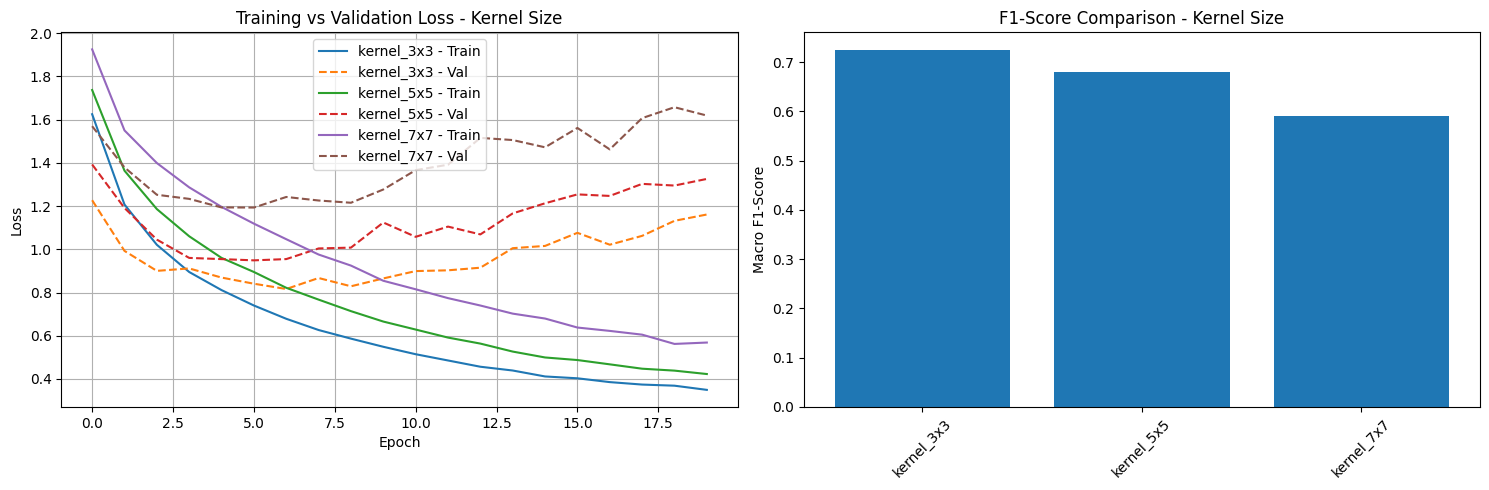

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, result in results_kernels.items():
    history = result['history']
    axes[0].plot(history.history['loss'], label=f'{name} - Train')
    axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')

axes[0].set_title('Training vs Validation Loss - Kernel Size')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

names = list(results_kernels.keys())
f1_scores = [results_kernels[name]['f1_macro'] for name in names]
axes[1].bar(names, f1_scores)
axes[1].set_title('F1-Score Comparison - Kernel Size')
axes[1].set_ylabel('Macro F1-Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\nKesimpulan Percobaan 3:")
for name, result in results_kernels.items():
    print(f"{name}: F1-Score = {result['f1_macro']:.4f}")


Kesimpulan Percobaan 3:
kernel_3x3: F1-Score = 0.7240
kernel_5x5: F1-Score = 0.6800
kernel_7x7: F1-Score = 0.5903


### Percobaan 4: Pengaruh Jenis Pooling Layer

In [ ]:
print("\n" + "=" * 60)
print("Percobaan 4: Pengaruh Jenis Pooling Layer")
print("=" * 60)

# Variasi 1: Max Pooling
model_max_pool = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 2: Average Pooling
model_avg_pool = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='average'
)

models_pooling = [
    (model_max_pool, "max_pooling"),
    (model_avg_pool, "average_pooling")
]

results_pooling = {}
for model, name in models_pooling:
    print(f"\nTraining {name}...")
    history, test_acc, f1_macro = train_model(model, name)
    results_pooling[name] = {
        'history': history,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }


Percobaan 4: Pengaruh Jenis Pooling Layer

Training max_pooling...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2865 - loss: 1.9187 - val_accuracy: 0.5161 - val_loss: 1.3378
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5043 - loss: 1.3671 - val_accuracy: 0.6191 - val_loss: 1.0620
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5924 - loss: 1.1435 - val_accuracy: 0.6657 - val_loss: 0.9337
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6372 - loss: 1.0240 - val_accuracy: 0.6914 - val_loss: 0.8841
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6744 - loss: 0.9185 - val_accuracy: 0.7071 - val_loss: 0.8386
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7020 - loss: 0.8440 - val_accuracy: 0.7188 - val_loss: 0.8187
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7232 - loss: 0.7835 - val_accuracy: 0.7153 - val_loss: 0.8254
Epoch 8/20
1250/1250


max_pooling Results:
Test Accuracy: 0.7382
Test F1-Score (Macro): 0.7370

Training average_pooling...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3034 - loss: 1.8906 - val_accuracy: 0.5233 - val_loss: 1.3250
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5057 - loss: 1.3597 - val_accuracy: 0.6078 - val_loss: 1.0950
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5860 - loss: 1.1654 - val_accuracy: 0.6454 - val_loss: 0.9829
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6272 - loss: 1.0432 - val_accuracy: 0.6770 - val_loss: 0.9232
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6650 - loss: 0.9439 - val_accuracy: 0.7066 - val_loss: 0.8509
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6921 - loss: 0.8764 - val_accuracy: 0.7041 - val_loss: 0.8575
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7149 - loss: 0.8042 - val_accuracy: 0.7209 - 


average_pooling Results:
Test Accuracy: 0.7357
Test F1-Score (Macro): 0.7312


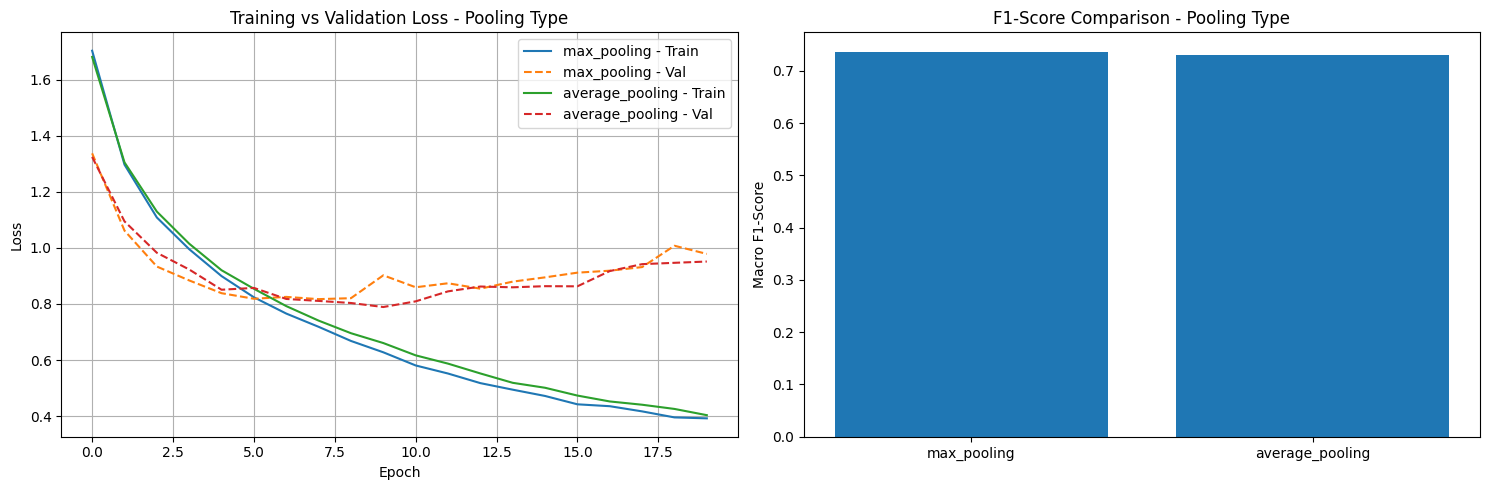

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, result in results_pooling.items():
    history = result['history']
    axes[0].plot(history.history['loss'], label=f'{name} - Train')
    axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')

axes[0].set_title('Training vs Validation Loss - Pooling Type')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

names = list(results_pooling.keys())
f1_scores = [results_pooling[name]['f1_macro'] for name in names]
axes[1].bar(names, f1_scores)
axes[1].set_title('F1-Score Comparison - Pooling Type')
axes[1].set_ylabel('Macro F1-Score')

plt.tight_layout()
plt.show()

In [ ]:
print("\nKesimpulan Percobaan 4:")
for name, result in results_pooling.items():
    print(f"{name}: F1-Score = {result['f1_macro']:.4f}")


Kesimpulan Percobaan 4:
max_pooling: F1-Score = 0.7370
average_pooling: F1-Score = 0.7312


## Model From Scratch

In [8]:
class Conv2DLayer:
    def __init__(self, weights, bias, activation='relu', padding='same'):
        self.weights = weights  # Shape: (kernel_h, kernel_w, input_channels, output_channels)
        self.bias = bias        # Shape: (output_channels,)
        self.activation = activation
        self.padding = padding

    def forward(self, x):
        batch_size, input_h, input_w, input_channels = x.shape
        kernel_h, kernel_w, _, output_channels = self.weights.shape

        # Calculate output dimensions
        if self.padding == 'same':
            output_h = input_h
            output_w = input_w
            pad_h = max(0, (kernel_h - 1) // 2)
            pad_w = max(0, (kernel_w - 1) // 2)
        else:  # 'valid'
            output_h = input_h - kernel_h + 1
            output_w = input_w - kernel_w + 1
            pad_h = pad_w = 0

        # Pad input
        if self.padding == 'same':
            x_padded = np.pad(x, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        else:
            x_padded = x

        # Initialize output
        output = np.zeros((batch_size, output_h, output_w, output_channels))

        # Perform convolution
        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(output_channels):
                        # Extract patch
                        patch = x_padded[b, h:h+kernel_h, w:w+kernel_w, :]
                        # Convolution operation
                        output[b, h, w, c] = np.sum(patch * self.weights[:, :, :, c]) + self.bias[c]

        # Apply activation
        if self.activation == 'relu':
            output = np.maximum(0, output)

        return output

class MaxPooling2DLayer:
    def __init__(self, pool_size=(2, 2)):
        self.pool_size = pool_size

    def forward(self, x):
        batch_size, input_h, input_w, channels = x.shape
        pool_h, pool_w = self.pool_size

        output_h = input_h // pool_h
        output_w = input_w // pool_w

        output = np.zeros((batch_size, output_h, output_w, channels))

        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        patch = x[b, h*pool_h:(h+1)*pool_h, w*pool_w:(w+1)*pool_w, c]
                        output[b, h, w, c] = np.max(patch)

        return output

class AveragePooling2DLayer:
    def __init__(self, pool_size=(2, 2)):
        self.pool_size = pool_size

    def forward(self, x):
        batch_size, input_h, input_w, channels = x.shape
        pool_h, pool_w = self.pool_size

        output_h = input_h // pool_h
        output_w = input_w // pool_w

        output = np.zeros((batch_size, output_h, output_w, channels))

        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        patch = x[b, h*pool_h:(h+1)*pool_h, w*pool_w:(w+1)*pool_w, c]
                        output[b, h, w, c] = np.mean(patch)

        return output

class FlattenLayer:
    def forward(self, x):
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)

class DenseLayer:
    def __init__(self, weights, bias, activation=None):
        self.weights = weights  # Shape: (input_dim, output_dim)
        self.bias = bias        # Shape: (output_dim,)
        self.activation = activation

    def forward(self, x):
        output = np.dot(x, self.weights) + self.bias

        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'softmax':
            exp_scores = np.exp(output - np.max(output, axis=1, keepdims=True))
            output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return output

class CNNFromScratch:
    def __init__(self, keras_model):
        # Initialize CNN from Keras model weights
        self.layers = []
        self._build_from_keras(keras_model)

    def _build_from_keras(self, keras_model):
        # Build CNN layers from Keras model
        for layer in keras_model.layers:
            if isinstance(layer, keras.layers.Conv2D):
                weights, bias = layer.get_weights()
                self.layers.append(Conv2DLayer(weights, bias, 'relu', layer.padding))

            elif isinstance(layer, keras.layers.MaxPooling2D):
                self.layers.append(MaxPooling2DLayer(layer.pool_size))

            elif isinstance(layer, keras.layers.AveragePooling2D):
                self.layers.append(AveragePooling2DLayer(layer.pool_size))

            elif isinstance(layer, keras.layers.Flatten):
                self.layers.append(FlattenLayer())

            elif isinstance(layer, keras.layers.Dense):
                weights, bias = layer.get_weights()
                activation = None
                if layer.activation.__name__ == 'relu':
                    activation = 'relu'
                elif layer.activation.__name__ == 'softmax':
                    activation = 'softmax'
                self.layers.append(DenseLayer(weights, bias, activation))

            elif isinstance(layer, keras.layers.Dropout):
                # Skip dropout in inference
                continue

    def predict(self, x, batch_size=32):
        n_samples = x.shape[0]
        predictions = []

        for i in range(0, n_samples, batch_size):
            batch_end = min(i + batch_size, n_samples)
            batch_x = x[i:batch_end]

            # Forward pass through all layers
            current_input = batch_x
            for layer in self.layers:
                current_input = layer.forward(current_input)

            predictions.append(current_input)

        return np.vstack(predictions)

## Forward Propagation Testing

In [9]:
print("\n" + "=" * 60)
print("TESTING FORWARD PROPAGATION IMPLEMENTATION")
print("=" * 60)

best_model = keras.models.load_model('models/average_pooling.h5')

custom_cnn = CNNFromScratch(best_model)

# Test on a small subset first
test_batch_size = 100
x_test_small = x_test[:test_batch_size]
y_test_small = y_test[:test_batch_size]

print(f"Testing on {test_batch_size} samples...")

# Keras predictions
keras_predictions = best_model.predict(x_test_small, verbose=0)
keras_classes = np.argmax(keras_predictions, axis=1)

# Custom implementation predictions
custom_predictions = custom_cnn.predict(x_test_small, batch_size=32)
custom_classes = np.argmax(custom_predictions, axis=1)

# Compare predictions
print(f"Keras predictions shape: {keras_predictions.shape}")
print(f"Custom predictions shape: {custom_predictions.shape}")

predictions_close = np.allclose(keras_predictions, custom_predictions, rtol=1e-4, atol=1e-4)
print(f"Predictions are close: {predictions_close}")

# Calculate differences
max_diff = np.max(np.abs(keras_predictions - custom_predictions))
mean_diff = np.mean(np.abs(keras_predictions - custom_predictions))
print(f"Maximum difference: {max_diff:.6f}")
print(f"Mean difference: {mean_diff:.6f}")

# Compare class predictions
same_predictions = np.sum(keras_classes == custom_classes)
print(f"Same class predictions: {same_predictions}/{test_batch_size} ({100*same_predictions/test_batch_size:.1f}%)")

# Calculate F1 scores
keras_f1 = f1_score(y_test_small, keras_classes, average='macro')
custom_f1 = f1_score(y_test_small, custom_classes, average='macro')

print(f"Keras F1-Score: {keras_f1:.4f}")
print(f"Custom F1-Score: {custom_f1:.4f}")
print(f"F1-Score difference: {abs(keras_f1 - custom_f1):.4f}")


TESTING FORWARD PROPAGATION IMPLEMENTATION


Testing on 100 samples...
Keras predictions shape: (100, 10)
Custom predictions shape: (100, 10)
Predictions are close: True
Maximum difference: 0.000001
Mean difference: 0.000000
Same class predictions: 100/100 (100.0%)
Keras F1-Score: 0.7398
Custom F1-Score: 0.7398
F1-Score difference: 0.0000


## Test Set Evaluation

In [10]:
print("\n" + "=" * 60)
print("FULL TEST SET EVALUATION")
print("=" * 60)

# Keras predictions on full test set
keras_predictions_full = best_model.predict(x_test, batch_size=32, verbose=1)
keras_classes_full = np.argmax(keras_predictions_full, axis=1)

# Custom implementation predictions on full test set
print("Running custom implementation...")
custom_predictions_full = custom_cnn.predict(x_test, batch_size=32)
custom_classes_full = np.argmax(custom_predictions_full, axis=1)

# Calculate F1 scores
keras_f1_full = f1_score(y_test, keras_classes_full, average='macro')
custom_f1_full = f1_score(y_test, custom_classes_full, average='macro')

print(f"\nFinal Results on Test Set:")
print(f"Keras F1-Score: {keras_f1_full:.4f}")
print(f"Custom Implementation F1-Score: {custom_f1_full:.4f}")
print(f"F1-Score difference: {abs(keras_f1_full - custom_f1_full):.4f}")

# Detailed classification report
print("\nKeras Classification Report:")
print(classification_report(y_test, keras_classes_full, target_names=class_names))

print("\nCustom Implementation Classification Report:")
print(classification_report(y_test, custom_classes_full, target_names=class_names))


FULL TEST SET EVALUATION
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Running custom implementation...

Final Results on Test Set:
Keras F1-Score: 0.7312
Custom Implementation F1-Score: 0.7312
F1-Score difference: 0.0000

Keras Classification Report:
              precision    recall  f1-score   support

    airplane       0.72      0.83      0.77      1000
  automobile       0.86      0.87      0.86      1000
        bird       0.62      0.62      0.62      1000
         cat       0.58      0.46      0.51      1000
        deer       0.69      0.68      0.69      1000
         dog       0.66      0.55      0.60      1000
        frog       0.73      0.84      0.78      1000
       horse       0.77      0.80      0.78      1000
        ship       0.84      0.85      0.85      1000
       truck       0.83      0.85      0.84      1000

    accuracy                           0.74     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.73      0.74      0.73     

## CNN with Backpropagation

In [11]:
class Conv2DLayerWithBackprop(Conv2DLayer):
    def __init__(self, weights, bias, activation='relu', padding='same'):
        super().__init__(weights, bias, activation, padding)
        self.last_input = None
        self.last_output = None

    def forward(self, x):
        self.last_input = x
        output = super().forward(x)
        self.last_output = output
        return output

    def backward(self, grad_output):
        batch_size, input_h, input_w, input_channels = self.last_input.shape
        kernel_h, kernel_w, _, output_channels = self.weights.shape

        # Apply activation derivative
        if self.activation == 'relu':
            grad_output = grad_output * (self.last_output > 0)

        # Initialize gradients
        grad_weights = np.zeros_like(self.weights)
        grad_bias = np.zeros_like(self.bias)
        grad_input = np.zeros_like(self.last_input)

        # Calculate padding
        if self.padding == 'same':
            pad_h = max(0, (kernel_h - 1) // 2)
            pad_w = max(0, (kernel_w - 1) // 2)
            x_padded = np.pad(self.last_input, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        else:
            pad_h = pad_w = 0
            x_padded = self.last_input

        output_h, output_w = grad_output.shape[1:3]

        # Calculate gradients
        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(output_channels):
                        # Gradient w.r.t. weights
                        patch = x_padded[b, h:h+kernel_h, w:w+kernel_w, :]
                        grad_weights[:, :, :, c] += patch * grad_output[b, h, w, c]

                        # Gradient w.r.t. bias
                        grad_bias[c] += grad_output[b, h, w, c]

                        # Gradient w.r.t. input
                        if pad_h > 0 or pad_w > 0:
                            start_h = max(0, h - pad_h)
                            end_h = min(input_h, h + kernel_h - pad_h)
                            start_w = max(0, w - pad_w)
                            end_w = min(input_w, w + kernel_w - pad_w)

                            kernel_start_h = max(0, pad_h - h)
                            kernel_end_h = kernel_start_h + (end_h - start_h)
                            kernel_start_w = max(0, pad_w - w)
                            kernel_end_w = kernel_start_w + (end_w - start_w)

                            grad_input[b, start_h:end_h, start_w:end_w, :] += \
                                self.weights[kernel_start_h:kernel_end_h, kernel_start_w:kernel_end_w, :, c] * grad_output[b, h, w, c]
                        else:
                            grad_input[b, h:h+kernel_h, w:w+kernel_w, :] += \
                                self.weights[:, :, :, c] * grad_output[b, h, w, c]

        return grad_input, grad_weights, grad_bias

class DenseLayerWithBackprop(DenseLayer):
    def __init__(self, weights, bias, activation=None):
        super().__init__(weights, bias, activation)
        self.last_input = None
        self.last_output = None

    def forward(self, x):
        self.last_input = x
        output = super().forward(x)
        self.last_output = output
        return output

    def backward(self, grad_output):
        # Apply activation derivative
        if self.activation == 'relu':
            grad_output = grad_output * (self.last_output > 0)
        elif self.activation == 'softmax':
            # For softmax, gradient is handled in loss function
            pass

        # Calculate gradients
        grad_weights = np.dot(self.last_input.T, grad_output)
        grad_bias = np.sum(grad_output, axis=0)
        grad_input = np.dot(grad_output, self.weights.T)

        return grad_input, grad_weights, grad_bias

class MaxPooling2DLayerWithBackprop(MaxPooling2DLayer):
    def __init__(self, pool_size=(2, 2)):
        super().__init__(pool_size)
        self.last_input = None
        self.max_indices = None

    def forward(self, x):
        self.last_input = x
        batch_size, input_h, input_w, channels = x.shape
        pool_h, pool_w = self.pool_size

        output_h = input_h // pool_h
        output_w = input_w // pool_w

        output = np.zeros((batch_size, output_h, output_w, channels))
        self.max_indices = np.zeros((batch_size, output_h, output_w, channels, 2), dtype=int)

        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        patch = x[b, h*pool_h:(h+1)*pool_h, w*pool_w:(w+1)*pool_w, c]
                        max_idx = np.unravel_index(np.argmax(patch), patch.shape)
                        output[b, h, w, c] = patch[max_idx]
                        self.max_indices[b, h, w, c, :] = [h*pool_h + max_idx[0], w*pool_w + max_idx[1]]

        return output

    def backward(self, grad_output):
        batch_size, input_h, input_w, channels = self.last_input.shape
        grad_input = np.zeros_like(self.last_input)

        output_h, output_w = grad_output.shape[1:3]

        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        max_h, max_w = self.max_indices[b, h, w, c, :]
                        grad_input[b, max_h, max_w, c] += grad_output[b, h, w, c]

        return grad_input

class AveragePooling2DLayerWithBackprop(AveragePooling2DLayer):
    def __init__(self, pool_size=(2, 2)):
        super().__init__(pool_size)
        self.last_input = None

    def forward(self, x):
        self.last_input = x
        return super().forward(x)

    def backward(self, grad_output):
        batch_size, input_h, input_w, channels = self.last_input.shape
        pool_h, pool_w = self.pool_size

        output_h = input_h // pool_h
        output_w = input_w // pool_w

        grad_input = np.zeros_like(self.last_input)

        # For average pooling, gradient is distributed equally across the pooling window
        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        # Distribute gradient equally across pool window
                        pool_area = pool_h * pool_w
                        avg_grad = grad_output[b, h, w, c] / pool_area

                        grad_input[b, h*pool_h:(h+1)*pool_h, w*pool_w:(w+1)*pool_w, c] += avg_grad

        return grad_input

class FlattenLayerWithBackprop:
    def __init__(self):
        self.last_input_shape = None

    def forward(self, x):
        self.last_input_shape = x.shape
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.last_input_shape)

class CNNFromScratchWithBackprop:
    def __init__(self, keras_model):
        self.layers = []
        self._build_from_keras(keras_model)

    def _build_from_keras(self, keras_model):
        for layer in keras_model.layers:
            if isinstance(layer, keras.layers.Conv2D):
                weights, bias = layer.get_weights()
                self.layers.append(Conv2DLayerWithBackprop(weights, bias, 'relu', layer.padding))

            elif isinstance(layer, keras.layers.MaxPooling2D):
                self.layers.append(MaxPooling2DLayerWithBackprop(layer.pool_size))

            elif isinstance(layer, keras.layers.AveragePooling2D):
                self.layers.append(AveragePooling2DLayerWithBackprop(layer.pool_size))

            elif isinstance(layer, keras.layers.Flatten):
                self.layers.append(FlattenLayerWithBackprop())

            elif isinstance(layer, keras.layers.Dense):
                weights, bias = layer.get_weights()
                activation = None
                if layer.activation.__name__ == 'relu':
                    activation = 'relu'
                elif layer.activation.__name__ == 'softmax':
                    activation = 'softmax'
                self.layers.append(DenseLayerWithBackprop(weights, bias, activation))

            elif isinstance(layer, keras.layers.Dropout):
                # Skip dropout in inference
                continue

    def predict(self, x, batch_size=32):
        n_samples = x.shape[0]
        predictions = []

        for i in range(0, n_samples, batch_size):
            batch_end = min(i + batch_size, n_samples)
            batch_x = x[i:batch_end]

            # Forward pass through all layers
            current_input = batch_x
            for layer in self.layers:
                current_input = layer.forward(current_input)

            predictions.append(current_input)

        return np.vstack(predictions)

    def forward_with_cache(self, x):
        activations = [x]
        current_input = x

        for layer in self.layers:
            current_input = layer.forward(current_input)
            activations.append(current_input)

        return current_input, activations

    def backward(self, grad_output, activations):
        gradients = []
        current_grad = grad_output

        # Go through layers in reverse order
        for i, layer in enumerate(reversed(self.layers)):
            layer_idx = len(self.layers) - 1 - i

            if isinstance(layer, (Conv2DLayerWithBackprop, DenseLayerWithBackprop)):
                grad_input, grad_weights, grad_bias = layer.backward(current_grad)
                gradients.insert(0, (grad_weights, grad_bias))
                current_grad = grad_input
            elif isinstance(layer, (MaxPooling2DLayerWithBackprop, AveragePooling2DLayerWithBackprop)):
                current_grad = layer.backward(current_grad)
                gradients.insert(0, None)  # No parameters to update
            elif isinstance(layer, FlattenLayerWithBackprop):
                current_grad = layer.backward(current_grad)
                gradients.insert(0, None)  # No parameters to update
        return gradients

In [13]:
# Example of how to use the custom CNN implementation
example_input = x_test[:5]  # 5 test samples
print(f"Example input shape: {example_input.shape}")

# Load any saved model
example_model = keras.models.load_model(f'models/average_pooling.h5')
example_custom_cnn = CNNFromScratch(example_model)

# Make predictions
keras_pred = example_model.predict(example_input, verbose=0)
custom_pred = example_custom_cnn.predict(example_input, batch_size=5)

print(f"Keras predictions shape: {keras_pred.shape}")
print(f"Custom predictions shape: {custom_pred.shape}")
print(f"Predictions match: {np.allclose(keras_pred, custom_pred, rtol=1e-4)}")

# Show predicted classes
keras_classes = np.argmax(keras_pred, axis=1)
custom_classes = np.argmax(custom_pred, axis=1)
actual_classes = y_test[:5]

print(f"\nPrediction comparison:")
print(f"Actual:  {actual_classes}")
print(f"Keras:   {keras_classes}")
print(f"Custom:  {custom_classes}")

for i in range(5):
    print(f"Sample {i}: {class_names[actual_classes[i]]} | "
          f"Keras: {class_names[keras_classes[i]]} | "
          f"Custom: {class_names[custom_classes[i]]}")

Example input shape: (5, 32, 32, 3)
Keras predictions shape: (5, 10)
Custom predictions shape: (5, 10)
Predictions match: True

Prediction comparison:
Actual:  [3 8 8 0 6]
Keras:   [3 8 8 0 6]
Custom:  [3 8 8 0 6]
Sample 0: cat | Keras: cat | Custom: cat
Sample 1: ship | Keras: ship | Custom: ship
Sample 2: ship | Keras: ship | Custom: ship
Sample 3: airplane | Keras: airplane | Custom: airplane
Sample 4: frog | Keras: frog | Custom: frog


In [12]:
print(f"\n" + "=" * 60)
print("BACKPROPAGATION TESTING")
print("=" * 60)

def test_all_implementations():
   # Load the best model
    print("Loading average_pooling.h5 model...")
    try:
        best_model = keras.models.load_model('models/average_pooling.h5')
        print("Successfully loaded average_pooling.h5")
    except:
        try:
            best_model = keras.models.load_model('average_pooling.h5')
            print("Successfully loaded average_pooling.h5")
        except:
            print("Error loading model, creating fallback...")
            best_model = create_cnn_model(
                conv_layers=[1, 1],
                filters_per_layer=[8, 16],
                kernel_sizes=[3, 3],
                pooling_type='average'
            )
            print("Training fallback model...")
            _, _, _ = train_model(best_model, 'fallback_model', epochs=2)

    # Test parameters
    test_batch_size = 100
    x_test_small = x_test[:test_batch_size]
    y_test_small = y_test[:test_batch_size]

    print(f"\nTesting on {test_batch_size} samples...")

    # =================================================================
    # 1. KERAS BASELINE PREDICTIONS
    # =================================================================
    print("\n" + "=" * 60)
    print("1. KERAS BASELINE PREDICTIONS")
    print("=" * 60)

    keras_predictions = best_model.predict(x_test_small, verbose=0)
    keras_classes = np.argmax(keras_predictions, axis=1)
    keras_f1 = f1_score(y_test_small, keras_classes, average='macro')

    print(f"Keras predictions shape: {keras_predictions.shape}")
    print(f"Keras F1-Score: {keras_f1:.4f}")

    # =================================================================
    # 2. CNNFROMSCRATCH (NO BACKPROP) TESTING
    # =================================================================
    print("\n" + "=" * 60)
    print("2. CNNFROMSCRATCH (NO BACKPROP) TESTING")
    print("=" * 60)

    # Create regular CNNFromScratch
    custom_cnn = CNNFromScratch(best_model)

    # Custom implementation predictions
    custom_predictions = custom_cnn.predict(x_test_small, batch_size=32)
    custom_classes = np.argmax(custom_predictions, axis=1)

    # Compare with Keras
    print(f"Custom predictions shape: {custom_predictions.shape}")

    predictions_close = np.allclose(keras_predictions, custom_predictions, rtol=1e-4, atol=1e-4)
    max_diff = np.max(np.abs(keras_predictions - custom_predictions))
    mean_diff = np.mean(np.abs(keras_predictions - custom_predictions))
    same_predictions = np.sum(keras_classes == custom_classes)
    custom_f1 = f1_score(y_test_small, custom_classes, average='macro')

    print(f"Predictions are close: {'YES' if predictions_close else 'NO'}")
    print(f"Maximum difference: {max_diff:.6f}")
    print(f"Mean difference: {mean_diff:.6f}")
    print(f"Same class predictions: {same_predictions}/{test_batch_size} ({100*same_predictions/test_batch_size:.1f}%)")
    print(f"Custom F1-Score: {custom_f1:.4f}")
    print(f"F1-Score difference vs Keras: {abs(keras_f1 - custom_f1):.4f}")

    # =================================================================
    # 3. CNNFROMSCRATCH WITH BACKPROP TESTING
    # =================================================================
    print("\n" + "=" * 60)
    print("3. CNNFROMSCRATCH WITH BACKPROP TESTING")
    print("=" * 60)

    # Create CNNFromScratch with backprop capability
    custom_cnn_backprop = CNNFromScratchWithBackprop(best_model)

    # Forward pass with activation caching
    print("Running forward pass with backprop implementation...")
    backprop_predictions, activations = custom_cnn_backprop.forward_with_cache(x_test_small)
    backprop_classes = np.argmax(backprop_predictions, axis=1)

    # Compare backprop forward pass with Keras
    print(f"Backprop predictions shape: {backprop_predictions.shape}")

    backprop_predictions_close = np.allclose(keras_predictions, backprop_predictions, rtol=1e-4, atol=1e-4)
    backprop_max_diff = np.max(np.abs(keras_predictions - backprop_predictions))
    backprop_mean_diff = np.mean(np.abs(keras_predictions - backprop_predictions))
    backprop_same_predictions = np.sum(keras_classes == backprop_classes)
    backprop_f1 = f1_score(y_test_small, backprop_classes, average='macro')

    print(f"Backprop predictions are close to Keras: {'YES' if backprop_predictions_close else 'NO'}")
    print(f"Backprop maximum difference vs Keras: {backprop_max_diff:.6f}")
    print(f"Backprop mean difference vs Keras: {backprop_mean_diff:.6f}")
    print(f"Backprop same class predictions vs Keras: {backprop_same_predictions}/{test_batch_size} ({100*backprop_same_predictions/test_batch_size:.1f}%)")
    print(f"Backprop F1-Score: {backprop_f1:.4f}")
    print(f"Backprop F1-Score difference vs Keras: {abs(keras_f1 - backprop_f1):.4f}")

    # Compare backprop vs regular custom implementation
    backprop_vs_custom_close = np.allclose(custom_predictions, backprop_predictions, rtol=1e-4, atol=1e-4)
    backprop_vs_custom_max_diff = np.max(np.abs(custom_predictions - backprop_predictions))
    backprop_vs_custom_same = np.sum(custom_classes == backprop_classes)

    print(f"\nBackprop vs Regular Custom Implementation:")
    print(f"Predictions are close: {'YES' if backprop_vs_custom_close else 'NO'}")
    print(f"Maximum difference: {backprop_vs_custom_max_diff:.6f}")
    print(f"Same class predictions: {backprop_vs_custom_same}/{test_batch_size} ({100*backprop_vs_custom_same/test_batch_size:.1f}%)")
    print(f"F1-Score difference: {abs(custom_f1 - backprop_f1):.4f}")

    # =================================================================
    # 4. BACKWARD PROPAGATION FUNCTIONALITY TESTING
    # =================================================================
    print("\n" + "=" * 60)
    print("4. BACKWARD PROPAGATION FUNCTIONALITY TESTING")
    print("=" * 60)

    # Create loss gradient (simulating cross-entropy loss)
    y_one_hot = np.eye(10)[y_test_small]
    loss_gradient = (backprop_predictions - y_one_hot) / test_batch_size

    print("Computing gradients with custom backward propagation...")
    gradients = custom_cnn_backprop.backward(loss_gradient, activations)

    # Analyze gradients
    weight_gradients = [g for g in gradients if g is not None]
    conv_gradients = [g for g in weight_gradients if len(g) == 2 and g[0].ndim == 4]
    dense_gradients = [g for g in weight_gradients if len(g) == 2 and g[0].ndim == 2]

    print(f"Total gradient sets computed: {len(weight_gradients)}")
    print(f"Convolutional layer gradients: {len(conv_gradients)}")
    print(f"Dense layer gradients: {len(dense_gradients)}")

    # Verify gradient properties
    gradient_checks = []

    for i, grad_set in enumerate(weight_gradients):
        if grad_set is not None:
            grad_weights, grad_bias = grad_set

            # Check gradient properties
            weights_finite = np.all(np.isfinite(grad_weights))
            bias_finite = np.all(np.isfinite(grad_bias))
            weights_nonzero = np.any(grad_weights != 0)
            bias_nonzero = np.any(grad_bias != 0)
            weights_magnitude = np.mean(np.abs(grad_weights))
            bias_magnitude = np.mean(np.abs(grad_bias))

            layer_type = "Conv2D" if grad_weights.ndim == 4 else "Dense"

            print(f"\nLayer {i+1} ({layer_type}) Gradient Analysis:")
            print(f"  Weights shape: {grad_weights.shape}")
            print(f"  Bias shape: {grad_bias.shape}")
            print(f"  Weights finite: {'YES' if weights_finite else 'NO'}")
            print(f"  Bias finite: {'YES' if bias_finite else 'NO'}")
            print(f"  Weights non-zero: {'YES' if weights_nonzero else 'NO'}")
            print(f"  Bias non-zero: {'YES' if bias_nonzero else 'NO'}")
            print(f"  Weights avg magnitude: {weights_magnitude:.6f}")
            print(f"  Bias avg magnitude: {bias_magnitude:.6f}")

            layer_ok = weights_finite and bias_finite and weights_nonzero and bias_nonzero
            gradient_checks.append(layer_ok)

    # =================================================================
    # 5. COMPREHENSIVE COMPARISON SUMMARY
    # =================================================================
    print("\n" + "=" * 60)
    print("5. COMPREHENSIVE COMPARISON SUMMARY")
    print("=" * 60)

    print(f"{'Method':<25} {'F1-Score':<10} {'Diff vs Keras':<15} {'Same Predictions':<18}")
    print("-" * 70)
    print(f"{'Keras (Baseline)':<25} {keras_f1:<10.4f} {'0.0000':<15} {f'{test_batch_size}/{test_batch_size} (100.0%)':<18}")
    print(f"{'Custom (No Backprop)':<25} {custom_f1:<10.4f} {abs(keras_f1 - custom_f1):<15.4f} {f'{same_predictions}/{test_batch_size} ({100*same_predictions/test_batch_size:.1f}%)':<18}")
    print(f"{'Custom (With Backprop)':<25} {backprop_f1:<10.4f} {abs(keras_f1 - backprop_f1):<15.4f} {f'{backprop_same_predictions}/{test_batch_size} ({100*backprop_same_predictions/test_batch_size:.1f}%)':<18}")

    # Sample predictions comparison
    print(f"\nSAMPLE PREDICTIONS (First 10 samples):")
    print("-" * 85)
    print(f"{'Sample':<8} {'True':<12} {'Keras':<12} {'Custom':<12} {'Backprop':<12} {'All Match':<10}")
    print("-" * 85)

    for i in range(min(10, test_batch_size)):
        true_label = class_names[y_test_small[i]]
        keras_pred = class_names[keras_classes[i]]
        custom_pred = class_names[custom_classes[i]]
        backprop_pred = class_names[backprop_classes[i]]

        all_match = (keras_classes[i] == custom_classes[i] == backprop_classes[i])
        match_symbol = "✅" if all_match else "❌"

        print(f"{i:<8} {true_label:<12} {keras_pred:<12} {custom_pred:<12} {backprop_pred:<12} {match_symbol:<10}")

test_all_implementations()


BACKPROPAGATION TESTING
Loading average_pooling.h5 model...
Successfully loaded average_pooling.h5

Testing on 100 samples...

1. KERAS BASELINE PREDICTIONS
Keras predictions shape: (100, 10)
Keras F1-Score: 0.7398

2. CNNFROMSCRATCH (NO BACKPROP) TESTING
Custom predictions shape: (100, 10)
Predictions are close: YES
Maximum difference: 0.000001
Mean difference: 0.000000
Same class predictions: 100/100 (100.0%)
Custom F1-Score: 0.7398
F1-Score difference vs Keras: 0.0000

3. CNNFROMSCRATCH WITH BACKPROP TESTING
Running forward pass with backprop implementation...
Backprop predictions shape: (100, 10)
Backprop predictions are close to Keras: YES
Backprop maximum difference vs Keras: 0.000001
Backprop mean difference vs Keras: 0.000000
Backprop same class predictions vs Keras: 100/100 (100.0%)
Backprop F1-Score: 0.7398
Backprop F1-Score difference vs Keras: 0.0000

Backprop vs Regular Custom Implementation:
Predictions are close: YES
Maximum difference: 0.000000
Same class predictions: 